# Sentiment Analysis

### Import the required packages

Installed Packages Azure.AI.OpenAI, 1.0.0-beta.14 dotenv.net, 3.1.3 Scriban, 5.9.1


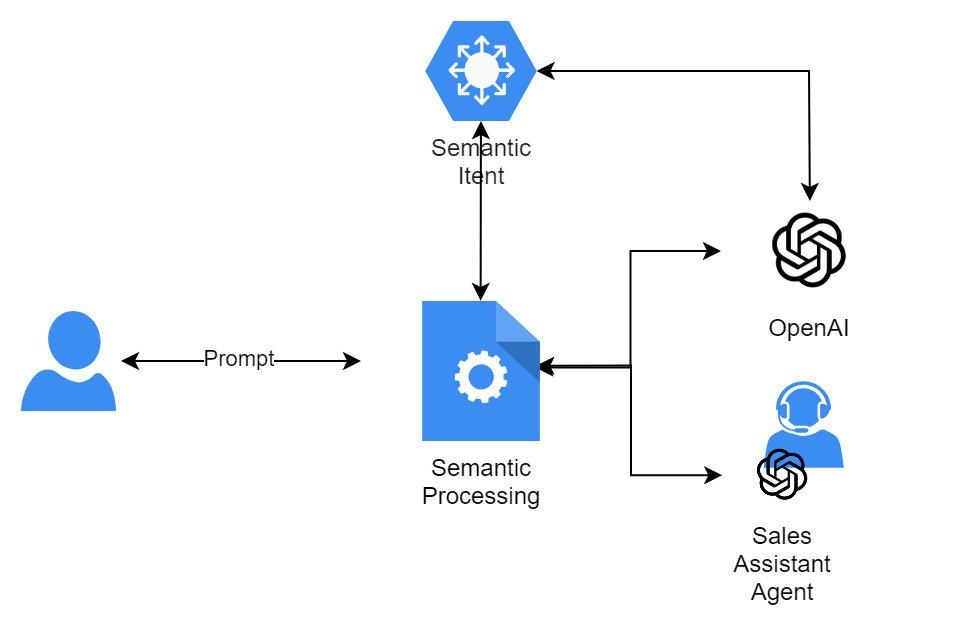

In [11]:
#r "nuget: Azure.AI.OpenAI, 1.0.0-beta.14"
#r "nuget: Scriban"
#r "nuget: dotenv.net"

using Azure;
using Azure.AI.OpenAI;
using Scriban;

using dotenv.net;
DotEnv.Load();

var endpoint=Environment.GetEnvironmentVariable("OPENAI_URI");
var key=Environment.GetEnvironmentVariable("OPENAI_KEY");
var model=Environment.GetEnvironmentVariable("OPENAI_GPT_DEPLOYMENT");




### Process a completion using the Azure SDK

In [11]:
async Task<string> ProcessCompletion(string prompt, int max_tokens=500, float temperature=0.3f)
{
    OpenAIClient client = new(new Uri(endpoint), new AzureKeyCredential(key));

    var chatCompletionsOptions = new ChatCompletionsOptions()
    {
        DeploymentName = model, //This must match the custom deployment name you chose for your model
        Messages =
        {
            new ChatRequestAssistantMessage(prompt),
        },
        MaxTokens = max_tokens,
        Temperature = temperature
    };

    Response<ChatCompletions> response = await client.GetChatCompletionsAsync(chatCompletionsOptions);

    return response.Value.Choices[0].Message.Content;
}

### Render an Scriban template

In [12]:
string RenderTemplate(string template, dynamic data) {
    var templateObject = Template.Parse(template);
    return templateObject.Render(data);
}

### Prepare a template and submit it for completion

In [13]:
string[] reviews = [
    "Mark S.: \"This smartphone has exceeded my expectations in every way. The camera quality is exceptional, capturing vivid details and colors. The battery life is impressive, easily lasting a full day with heavy usage. The sleek design and intuitive interface make it a pleasure to use. I'm a satisfied customer and would recommend it to anyone!\"",
    "Maya L.: \"I've been using this phone for a few weeks now, and it's a game-changer. The processing speed is fantastic, and I've experienced no lag even with multiple apps running. The display is vibrant, making videos and games look stunning. The fingerprint sensor is quick and accurate. Overall, a solid choice for anyone looking for a reliable and feature-packed smartphone.\"",
    "David W.: \"What sets this smartphone apart is its seamless integration with other devices. The ecosystem it creates is truly impressive, making my daily tasks more efficient. The build quality is robust, and the phone feels great in hand. The software updates have been regular, showing a commitment to keeping the device up to date. I'm very happy with my purchase.\"",
    "Jennifer P.: \"The smartphone is decent overall. The camera takes good photos, and the battery life is acceptable. However, I expected a bit more from the performance – there's a slight lag at times, especially when running resource-intensive apps. The design is standard, nothing particularly eye-catching. It's a reliable phone, but not a standout in the market.\"",
    "Ryan M.: \"This smartphone is a complete disappointment. The camera quality is subpar, producing grainy and washed-out photos. The battery drains rapidly, and even with minimal usage, it struggles to last half a day. The software is buggy, with frequent crashes and unresponsive touch screen. Save yourself the trouble and look elsewhere. This phone is not worth the money.\"",    
];

//# Create a semantic kernel inline function
var sentiment_template = @"From 1-10, 10 being a an excellent sentiment. What is the sentiment for: {{input}}?

Output format: {""sentiment"": 5}

Output in JSON format only.";


//Console.WriteLine(await process_competion(render_tempate(analysis_template, new { input = input })));

In [20]:
record Score(int sentiment);
var total_score = 0;
foreach(var review in reviews)
{
    var prompt = RenderTemplate(sentiment_template, new {input=review});
    var json_data = await ProcessCompletion(prompt,20);
    var data = System.Text.Json.JsonSerializer.Deserialize<Score>(json_data);
    total_score += data.sentiment;
}

var avg = total_score / reviews.Length;
Console.WriteLine($"Average sentiment score: {avg}");

{"sentiment": 10}
{"sentiment": 10}
{"sentiment": 9}
{"sentiment": 5}
{"sentiment": 1}
Average sentiment score: 7



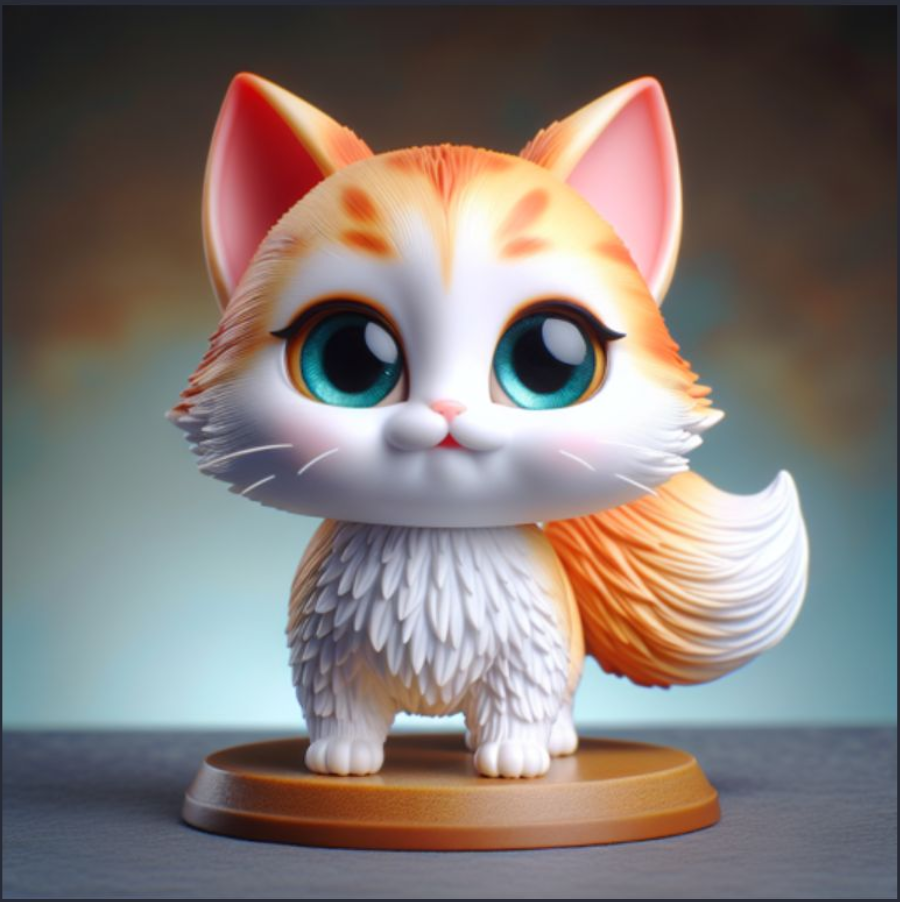

In [16]:
var imageBytes = System.IO.File.ReadAllBytes("data//funko-cat.png");
// Convert so we can display it as HTML
var b64 = Convert.ToBase64String(imageBytes);
var imgTag ="<img src='data:image/png;base64,{b64}'></img>"
.Replace("{b64}", b64);
HTML(imgTag)